In [1]:
%matplotlib notebook
import numpy as np
import json
import os, math
import pandas as pd
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from IPython.display import clear_output, display

from alvra_tools.load_data import *
from alvra_tools.channels import *
#from alvra_tools.channels_raw import *
from alvra_tools.utils import errfunc_sigma, errfunc_fwhm, threshold
import glob
from ipyfilechooser import FileChooser

### Choose the json file:

In [2]:
fc = FileChooser('/sf/alvra/data/p17589/raw/scan_info/')  #this is for RC
fc.use_dir_icons = True
display(fc)

FileChooser(path='/sf/alvra/data/p17589/raw/scan_info', filename='', show_hidden='False')

### Next cell: Signal (NO TT CORRECTED) calculated Shot-to-shot and averaged

In [5]:
quantile_laser = 0.68

channel_list_pp = [channel_Events, channel_LaserDiode, channel_Laser_refDiode]
channel_list_all = channel_list_pp + [channel_Izero117, channel_delay_harm]

########################################################################
json_file = fc.selected
print (json_file)
#json_file = DIR_json + "scan0010_2020-07-03-SiN4_5_scan_info.json"
#json_file = DIR_json + scan_name + ".json"

with open(json_file) as file:
    data = json.load(file)
numFiles = len(data['scan_files'])
#numFiles = 1
print ("Processing",numFiles,"files")

Pump_probe_all = []
Pump_probe = []
Pump_probe_avg =[]
Pump_probe_std = []
Pump_probe_std_err = []
Delay_mm = []

for i in range(0,numFiles):
    filename = (data['scan_files'][i])
    testdata = check_files_and_data(filename[0])

    if (testdata):# and (i!=16):
        clear_output(wait=True)
       
        print("step",i+1,"of",numFiles,": Processing %s" % (filename))
        
        resultsPP, results_FEL, pids_pump, pids_unpump = load_data_compact_FEL_pump(channel_list_pp, channel_list_all, filename[0])
        
        #(Laser_pump, Laser_unpump, Laser_ref_pump, Laser_ref_unpump, Izero_FEL, PIPS, delay, pids_loop) = \
        #load_YAG_events(str(data['scan_files'][i][0]))
        
        Laser_pump = resultsPP[channel_LaserDiode].pump
        Laser_ref_pump = resultsPP[channel_Laser_refDiode].pump
        Laser_unpump = resultsPP[channel_LaserDiode].unpump
        Laser_ref_unpump = resultsPP[channel_Laser_refDiode].unpump
        
        Izero_FEL = results_FEL[channel_Izero117]
        Delay_shot = results_FEL[channel_delay_harm]
        
        #Laser_diff = -np.log10((Laser_pump/Laser_ref_pump) / (Laser_unpump/ Laser_ref_unpump)) #/ (Izero_FEL)
        Laser_diff = -np.log10((Laser_pump) / (Laser_unpump))
        #Laser_diff = ((Laser_pump) / (Laser_unpump))
        
        Pump_probe_all.append(Laser_diff)
        df_pump_probe = pd.DataFrame(Laser_diff)
        Pump_probe.append(np.nanquantile(df_pump_probe, [0.5, 0.5 - quantile_laser/2, 0.5 + quantile_laser/2]))
        
        Pump_probe_std.append(np.nanmean(Laser_diff))
        Pump_probe_std_err.append(np.nanstd(Laser_diff))#/np.sqrt(len(Laser_diff)))
            
        Pump = np.median(Laser_pump)
        Unpump = np.median(Laser_unpump)
        Pump_probe_avg.append(-np.log10((Pump) / (Unpump)))
        
#        Delay_mm.append(data['scan_readbacks'][i]) ## Delay from the json file

        Delay_shot = [x for x in Delay_shot if (np.abs(x) > 0)]
        Delay_mm.append([np.median(Delay_shot)])
        
Pump_probe_all = np.asarray(Pump_probe_all)
Pump_probe = np.asarray(Pump_probe)
Pump_probe_avg = np.asarray(Pump_probe_avg)
Pump_probe_std = np.asarray(Pump_probe_std)
Pump_probe_std_err = np.asarray(Pump_probe_std_err)

minlen = min(len(i) for i in Pump_probe_all)
def cut(arr, minlen):
    return np.array([i[:minlen] for i in arr])
Pump_probe_all = cut(Pump_probe_all, minlen)


Delay_mm = np.asarray(Delay_mm)
print ("PBPS data of the last step have {} shots, avg intensity = {} +/- {}".format(len(Izero_FEL),round(np.average(Izero_FEL),4), round(np.std(Izero_FEL),4)))
print ("Quantile range = {}".format(0.5 - quantile_laser/2), 0.5 + quantile_laser/2)
print ("Loaded {} files, size of the arrays = {}".format(numFiles, len(Pump_probe)))
print ("Shape of pump probe data is {}".format(Pump_probe_all.shape))


step 51 of 51 : Processing ['/sf/alvra/data/p17589/raw/scan_data/Loop_thin_YAG_scan_harm_0/run_002661.BSREAD.h5']
Pump rep rate (FEL) is 50.0 Hz
Probe rep rate (laser) is 100.0 Hz

--------------------------------------------------------------------------------

SAR-CVME-TIFALL5:EvtSet       1001 / 1001 ->  0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS117:INTENSITY      490 / 1001 -> 51% loss ▇▇▇▇
SLAAR11-LMOT-M453:ENC_1_BS    1001 / 1001 ->  0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LSCP1-FNS:CH0:VAL_GET 1001 / 1001 ->  0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LSCP1-FNS:CH2:VAL_GET 1001 / 1001 ->  0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 490 / 1001 -> 51% loss
complete channels: 4 / 5 -> 20% incomplete

--------------------------------------------------------------------------------

PBPS data of the last step have 489 shots, avg intensity = 2.8659 +/- 0.1848
Quantile range = 0.15999999999999998 0.8400000000000001
Loaded 51 files, size of the arrays = 51
Shape of pump probe data is (51, 459)


/sf/alvra/anaconda/alvra-analysis/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


 ### Plot pump probe signals as a function of delay (stage mm)

<IPython.core.display.Javascript object>


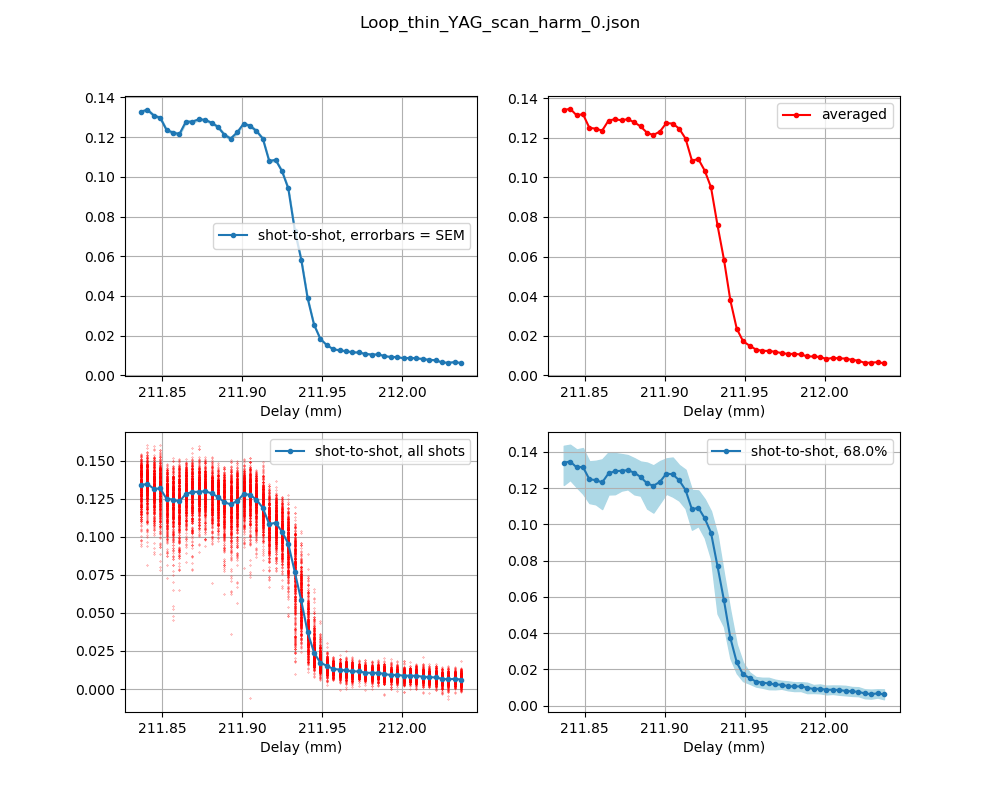

In [6]:
pp = Pump_probe[:,0]
err_pp_low = Pump_probe[:,1]
err_pp_high = Pump_probe[:,2]

plt.figure(figsize = (10,8))
plt.suptitle (fc.selected_filename)

plt.subplot(221)
plt.plot(Delay_mm, Pump_probe_std, label='shot-to-shot, errorbars = SEM', marker='.')
plt.fill_between(np.squeeze(Delay_mm), (Pump_probe_std-Pump_probe_std_err/ np.sqrt(minlen)), (Pump_probe_std+Pump_probe_std_err/ np.sqrt(minlen)), color='lightblue')
plt.xlabel("Delay (mm)")
plt.legend(loc='best')
plt.grid()

plt.subplot(222)
plt.plot(Delay_mm, Pump_probe_avg, label="averaged", color = 'r', marker='.')
plt.xlabel("Delay (mm)")
plt.legend(loc="best")
plt.grid()
plt.show()

plt.subplot(223)
for i in range(len(Delay_mm)):
    xe = Delay_mm[i]
    ye = Pump_probe_all[i,:]
    plt.plot([xe] * len(ye), ye, 'r.', ms=.5, alpha=0.8)
plt.plot(Delay_mm, pp, label='shot-to-shot, all shots', marker='.')
plt.xlabel("Delay (mm)")
plt.legend(loc="best")
#plt.ylim(-0.04, 0.08)
plt.grid()

plt.subplot(224)
plt.plot(Delay_mm, pp, label='shot-to-shot, {}%'.format(quantile_laser*100), marker='.')
plt.fill_between(np.squeeze(Delay_mm), err_pp_low, err_pp_high, color='lightblue')
plt.xlabel("Delay (mm)")
plt.legend(loc="best")
#plt.ylim(-0.04, 0.08)
#plt.xlim(190.05,190.1)
plt.grid()

savedir = "/das/work/p17/p17589/Export_PNG/"
#plt.savefig (savedir + 'SiN_5_raw_scan.png')

 ### Extract t0 from the fit 

In [10]:
pp = Pump_probe[:,0]

# Get a rough estimate of timezero in mm from the plot just above.
Timezero = 211.92

Pump_probe_toFit = pp.copy()
Delay_mm_toFit = np.copy(Delay_mm).T[0]
Delay_fs_toFit = (Delay_mm_toFit - Timezero)*2/(3e8*1e3*1e-15) # change to right t0 !

In [11]:
# Now fit with error funciton
index = ~(np.isnan(Delay_mm_toFit) | np.isnan(Pump_probe_toFit))

parameters_mm,extras = curve_fit(errfunc_fwhm, Delay_mm_toFit[index], Pump_probe_toFit[index], p0 = [0, 0.02, Timezero, 10])
t0_mm = parameters_mm[2]
width_mm = parameters_mm[3]

print("Position t0 =",np.round(t0_mm,5),"mm")
print("Width =",np.abs(np.round(width_mm,3))*1000,"um")

Position t0 = 211.93414 mm
Width = 27.0 um


In [12]:
# Now fit IN TIME with error funciton (defined above)
index = ~(np.isnan(Delay_fs_toFit) | np.isnan(Pump_probe_toFit))
parameters_fs,extras = curve_fit(errfunc_fwhm, Delay_fs_toFit[index], Pump_probe_toFit[index], p0 = [0, 0.2, 0, 100])
t0_fs = parameters_fs[2]
width_fs = parameters_fs[3]

print("Position t0 =",np.round(t0_fs,5),"fs")
print("Width =",np.abs(np.round(width_fs,5)),"fs")

Position t0 = 94.29255 fs
Width = 179.05962 fs


<IPython.core.display.Javascript object>


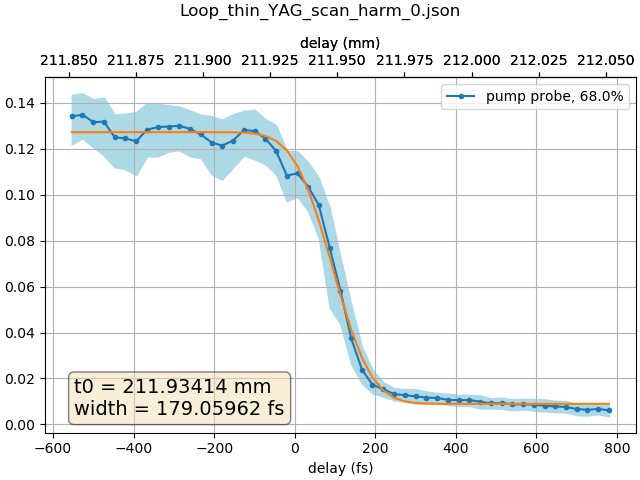

In [38]:
fig, ax = plt.subplots(constrained_layout=True)
#fig, ax = plt.subplots()
plt.suptitle (fc.selected_filename)
plt.plot(Delay_fs_toFit, pp, label='pump probe, {}%'.format(quantile_laser*100),marker='.')
plt.fill_between(np.squeeze(Delay_fs_toFit), err_pp_low, err_pp_high, color='lightblue')
plt.plot(Delay_fs_toFit, errfunc_fwhm(Delay_fs_toFit,*parameters_fs))
plt.grid()
plt.xlabel("delay (fs)")
plt.legend(loc="best")

def mm2fs(x):
    return (x-Timezero)*2/(3e8*1e3*1e-15)

def fs2mm(x):
    return Timezero + x * (3e8*1e3*1e-15)/2

secax = ax.secondary_xaxis('top', functions = (fs2mm, mm2fs))
secax.set_xlabel('delay (mm)')

boxstyle = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
boxtext = '\n'.join((r't0 = {} mm'.format(np.round(t0_mm, 5)),
                   r'width = {} fs'.format(np.abs(np.round(width_fs, decimals = 5)))))
plt.text(0.05, 0.05, boxtext, transform=ax.transAxes, bbox=boxstyle, fontsize=14)

plt.show()

<IPython.core.display.Javascript object>


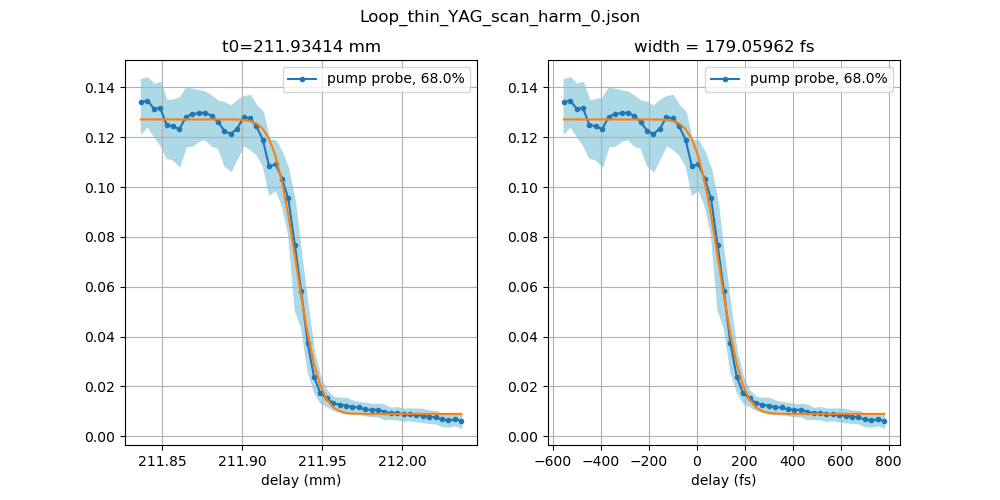

t0 = 211.93414 mm
Time step = 26.664960000175597 fs


In [21]:
#... and the plot with the fit curves

plt.figure(figsize = (10,5))
plt.suptitle (fc.selected_filename)
plt.subplot(121)


plt.plot(Delay_mm_toFit, pp, label='pump probe, {}%'.format(quantile_laser*100),marker='.')
plt.fill_between(np.squeeze(Delay_mm_toFit), err_pp_low, err_pp_high, color='lightblue')
plt.plot(Delay_mm_toFit, errfunc_fwhm(Delay_mm_toFit,*parameters_mm))
plt.grid()
plt.xlabel("delay (mm)")
plt.legend(loc="best")
plt.gca().set_title('Pump-probe vs Delay (mm)')
plt.legend(loc="best")
plt.title('t0=' + str(np.round(t0_mm, 5)) + ' mm' )


plt.subplot(122)

plt.plot(Delay_fs_toFit, pp, label='pump probe, {}%'.format(quantile_laser*100),marker='.')
plt.fill_between(np.squeeze(Delay_fs_toFit), err_pp_low, err_pp_high, color='lightblue')
plt.plot(Delay_fs_toFit, errfunc_fwhm(Delay_fs_toFit,*parameters_fs))
plt.grid()
plt.xlabel("delay (fs)")
plt.legend(loc="best")
plt.gca().set_title('width = {} fs'.format(np.abs(round(width_fs, 5))))
plt.legend(loc="best")
#plt.title('width=' + str(np.round(width_ps_ps, 5)) + ' fs' )

print ('t0 = {} mm'.format(np.round(t0_mm, 5)))
print ('Time step = {} fs'.format((Delay_fs_toFit[1]-Delay_fs_toFit[0])))
plt.show()
#plt.savefig (savedir + 'SiN_5_fit.png')

## Now with TT (PSEN) jitter correction

In [22]:
from scipy import optimize
from scipy.interpolate import interp1d
from scipy import signal
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d
from scipy.stats import binned_statistic
from scipy.ndimage import gaussian_filter1d
from scipy.ndimage import convolve1d
from scipy.special import erf

lambdas = 467.55 + 0.07219*np.arange(0,2047)      #calibration new spec 23-9-2020
nus = 299792458 / (lambdas * 10**-9)
nus_new = np.linspace(nus[0], nus[-1], num=2047, endpoint=True)
#filter = np.concatenate((np.ones(5), 1-signal.tukey(65), np.ones(1430), np.zeros(1500)))
filter = np.concatenate((np.ones(50),signal.tukey(40)[20:40], np.zeros(1977), np.zeros(2047)))
filter3 = np.concatenate((np.zeros(100), np.ones(100)))
pixelNum = np.arange(0,2047)

#######################################################################################################3

background_from_fit = np.loadtxt('/sf/alvra/data/p17589/scratch/2020-10-10-16:10-psen-background.txt')

px2fs = 1.993008440575784      # new spectrometer, it is ~ 2 px to fs
p0 = 1024

In [23]:
quantile_laser = 0.68
Timezero = 211.93414        

channel_list_pp = [channel_Events, channel_LaserDiode, channel_Laser_refDiode, channel_delay_harm,
                   channel_PSEN_signal, channel_PSEN_bkg]
channel_list_all = channel_list_pp # + [channel_Izero117]

#######################################################################
import itertools
json_file = fc.selected
#json_file = DIR_json + "scan0010_2020-07-03-SiN4_5_scan_info.json"
#json_file = DIR_json + scan_name + ".json"

with open(json_file) as file:
    data = json.load(file)
numFiles = len(data['scan_files'])
#numFiles = 1
print ("Processing",numFiles,"files")
print (json_file)

run_number = []
Delays_stage = []
Delay_fs_stage = []
edgePos = []
edgePosRun = []
Pump_probe_all = []
Pump_probe = []
sigtraces = []
peaktraces = []


for i in range(0,numFiles):
    filename = (data['scan_files'][i])
    testdata = check_files_and_data(filename[0])

    if (testdata):# and (i!=24):
        clear_output(wait=True)
       
        print("step",i+1,"of",numFiles,": Processing %s" % (filename))
        
        resultsPP, results_FEL, _, _ = load_data_compact_FEL_pump(channel_list_pp, channel_list_all, filename[0])
        
        Laser_pump = resultsPP[channel_LaserDiode].pump
        Laser_ref_pump = resultsPP[channel_Laser_refDiode].pump
        Laser_unpump = resultsPP[channel_LaserDiode].unpump
        Laser_ref_unpump = resultsPP[channel_Laser_refDiode].unpump
        sig = resultsPP[channel_PSEN_signal].pump
        back = resultsPP[channel_PSEN_bkg].pump
        delay_shot = resultsPP[channel_delay_harm].pump
        
        delay_shot_fs = (delay_shot - Timezero)*2/(3e8*1e3*1e-15)
        Delay_fs_stage.append(delay_shot_fs.mean())
        
  #      Izero_FEL = results_FEL[channel_Izero117]
        
        Laser_diff = -np.log10((Laser_pump) / (Laser_unpump))
        
        Pump_probe_all.append(Laser_diff)
        df_pump_probe = pd.DataFrame(Laser_diff)
        Pump_probe.append(np.nanquantile(df_pump_probe, [0.5, 0.5 - quantile_laser/2, 0.5 + quantile_laser/2]))
        
        
        for k in range(0, len(sig)):
            # background subtraction
            sig2 = np.nan_to_num(sig[k] / back[k]) / background_from_fit
    
            # interpolate to get evenly sampled in frequency space
            sig3inter = interp1d(nus, sig2, kind='cubic')
            sig4 = np.pad(sig3inter(nus_new), (0,len(sig3inter(nus_new))), 'constant', constant_values=0)
            sig4power = np.abs(np.fft.fft(sig4))**2

            # Fourier transform, filter, inverse fourier transform, take the real part, and do a moving average
            sig4fft = np.fft.fft(sig4)
            sig4filtered = sig4fft * filter
            sig4inverse = np.fft.ifft(sig4filtered)
            sig4invreal = 2 * np.real(sig4inverse)
            
            sig4inter = interp1d(nus_new, sig4invreal[0:2047], kind='cubic')
            sig5 = sig4inter(nus)
            sig5gaussO0 = gaussian_filter1d(sig5, 50)
            sig5gaussO1 = gaussian_filter1d(sig5, 50, order = 1)
            sig6 = np.roll(convolve1d(sig5gaussO0,filter3), -100)
    
            peak2 = np.argmax(sig5gaussO1)
        
            #if (peakxcorr > 0) & (peak2.max() > 0.05): 
            edgePos.append(peak2)
            Delays_stage.append(np.round(np.mean(delay_shot_fs),4))
            sigtraces.append(sig6)
            peaktraces.append(sig5gaussO1)
                #Pump_probe_all.append(Laser_diff)
            #edgeSig.append(sig5)
            
        edgePosRun.append(np.array(np.nanmean(edgePos)))
        
Pump_probe_all = list(itertools.chain.from_iterable(Pump_probe_all))

Delays_corr = Delays_stage + ((p0 - np.array(edgePos))*px2fs)

Pump_probe = np.asarray(Pump_probe)



step 51 of 51 : Processing ['/sf/alvra/data/p17589/raw/scan_data/Loop_thin_YAG_scan_harm_0/run_002661.BSREAD.h5']
Pump rep rate (FEL) is 50.0 Hz
Probe rep rate (laser) is 100.0 Hz

--------------------------------------------------------------------------------

SAR-CVME-TIFALL5:EvtSet                     1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M2.roi_background_x_profile 1000 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M2.roi_signal_x_profile     1000 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LMOT-M453:ENC_1_BS                  1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LSCP1-FNS:CH0:VAL_GET               1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LSCP1-FNS:CH2:VAL_GET               1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 1000 / 1001 -> 0% loss
complete channels: 4 / 6 -> 33% incomplete

--------------------------------------------------------------------------------



In [26]:
binsize = 10 # in fs

################################################################################################3
print (np.shape(Pump_probe_all),np.shape(Delays_corr))

#binList = np.arange(Delay_fs_stage[0], Delay_fs_stage[-1], binsize)
#xAxis = np.arange(Delay_fs_stage[0] + binsize/2, Delay_fs_stage[-1] - binsize/2, binsize)

binList = np.arange(Delays_corr[0], Delays_corr[-1], binsize)
xAxis = np.arange(Delays_corr[0] + binsize/2, Delays_corr[-1] - binsize/2, binsize)

s, binEdges, binNumber = binned_statistic(Delays_corr, Pump_probe_all, statistic='mean', bins=binList)

(25459,) (25459,)


 ### Extract t0 from the fit 

In [31]:
index = ~(np.isnan(xAxis) | np.isnan(s))
parameters_TTcorr,extras = curve_fit(errfunc_fwhm, xAxis[index], s[index], p0 = [0, 0.2, 0, 100])
t0_TTcorr = parameters_TTcorr[2]
width_TTcorr = parameters_TTcorr[3]

print("Position t0_corr = {} ps relative to {} mm".format(np.round(t0_TTcorr,5), Timezero))
print("Width =",np.abs(np.round(width_TTcorr,5)),"fs")

Position t0_corr = -96.20402 ps relative to 211.93414 mm
Width = 178.16954 fs


<IPython.core.display.Javascript object>


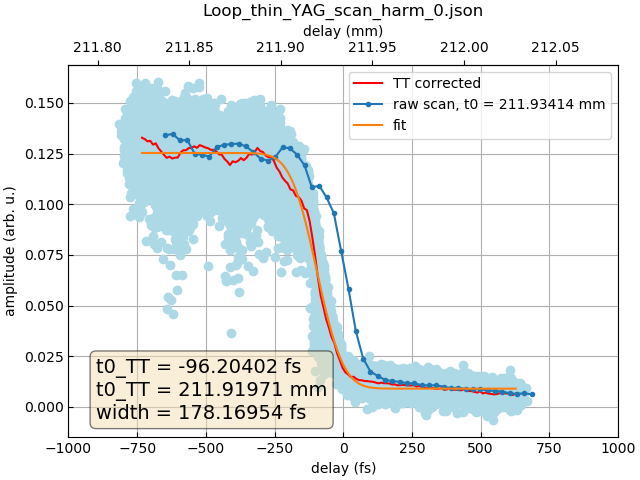

Position t0_TT = 211.91970939644608 mm


In [51]:
pp_uncorrected = Pump_probe[:,0]

fig, ax = plt.subplots(constrained_layout=True)
#plt.figure(constrained_layout=True)
plt.title(fc.selected_filename)
plt.tick_params(direction='in')
plt.plot(Delays_corr, Pump_probe_all, 'o', color='lightblue')
plt.plot(xAxis, s, color='red', label = 'TT corrected')
plt.xlabel('delay (fs)')
plt.ylabel('amplitude (arb. u.)')
plt.plot(Delay_fs_stage, pp_uncorrected, marker='.',label = 'raw scan, t0 = {} mm'.format(Timezero))
plt.plot(xAxis, errfunc_fwhm(xAxis,*parameters_TTcorr), label = 'fit')
plt.legend (loc = 'best')

secax = ax.secondary_xaxis('top', functions = (fs2mm, mm2fs))
secax.set_xlabel('delay (mm)')

boxstyle = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
boxtext = '\n'.join((r't0_TT = {} fs'.format(np.round(t0_TTcorr, 5)),
                     r't0_TT = {} mm'.format(np.round(Timezero + t0_TTcorr* (3e8*1e3*1e-15)/2,5)),
            r'width = {} fs'.format(np.abs(np.round(width_TTcorr, decimals = 5)))))
plt.text(0.05, 0.05, boxtext, transform=ax.transAxes, bbox=boxstyle, fontsize=14)

plt.xlim(-1000, 1000)
#plt.ylim(-0.01, 0.01)

plt.grid()
plt.show()

print("Position t0_TT = {} mm".format(Timezero + t0_TTcorr* (3e8*1e3*1e-15)/2))

<IPython.core.display.Javascript object>


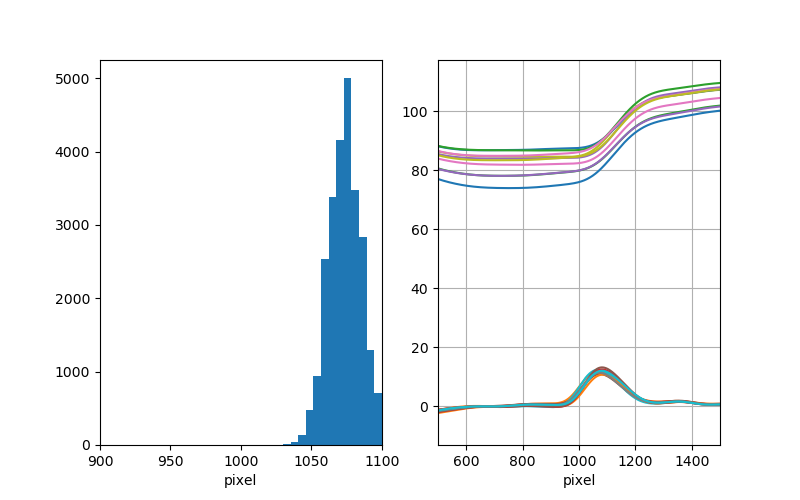

Peak of the histogram is at 1073.9305942888566 pixels
Offset compared to p0 = 1024 pixel is -99.5120958606562 fs
Jitter, i.e. width (std) of the histogram 26.775417510936766 fs


In [52]:
plt.figure(figsize = (8,5))
plt.subplot(121)
plt.hist(edgePos, bins=200)
plt.xlim(900,1100)
plt.xlabel('pixel')

plt.subplot(122)
for i in range(10):
   # plt.plot(sigtraces[i][200:1500])
    plt.plot(pixelNum[100:2047], sigtraces[i][0:1947])
    plt.plot(pixelNum, peaktraces[i]*10000)
plt.xlabel ('pixel')
plt.xlim(500,1500)
plt.grid()
plt.show()

print("Peak of the histogram is at {} pixels".format(np.mean(edgePos)))
print("Offset compared to p0 = {} pixel is {} fs".format(p0, ((p0 - np.mean(edgePos))*px2fs)))
print("Jitter, i.e. width (std) of the histogram {} fs".format(np.std(edgePos)*px2fs))

# Loop over several runs

In [2]:
datafiles = []
for file in glob.glob('/sf/alvra/data/p17589/raw/scan_info/Loop_thin_YAG_scan_harm_*'):
    datafiles.append(file)
datafiles = sorted(datafiles, key = os.path.getmtime)
#datafiles[:-3]

## without TT correction

In [11]:
quantile_laser = 0.68

Timezero_loop = 211.93414

channel_list_pp = [channel_Events, channel_LaserDiode, channel_Laser_refDiode]
channel_list_all = channel_list_pp + [channel_Izero117, channel_delay_harm]

########################################################################

width_fs_loop = []
t0_fs_loop =[]


for json_file in datafiles[:-3]:
    print (json_file)

    with open(json_file) as file:
        data = json.load(file)
    numFiles = len(data['scan_files'])
    #numFiles = 1
    print ("Processing",numFiles,"files")

    Pump_probe_all = []
    Pump_probe = []
    Pump_probe_avg =[]
    Pump_probe_std = []
    Pump_probe_std_err = []
    Delay_mm = []

    for i in range(0,numFiles):
        filename = (data['scan_files'][i])
        testdata = check_files_and_data(filename[0])
        avoid = (int(filename[0].split('/')[-1].split('.')[0].split('_')[-1]) != 4377)
        
        if (testdata) and (avoid): # and (i!=16):
            clear_output(wait=True)
       
            print("step",i+1,"of",numFiles,": Processing %s" % (filename))
        
            resultsPP, results_FEL, pids_pump, pids_unpump = load_data_compact_FEL_pump(channel_list_pp, channel_list_all, filename[0])
        
            #(Laser_pump, Laser_unpump, Laser_ref_pump, Laser_ref_unpump, Izero_FEL, PIPS, delay, pids_loop) = \
            #load_YAG_events(str(data['scan_files'][i][0]))
        
            Laser_pump = resultsPP[channel_LaserDiode].pump
            Laser_ref_pump = resultsPP[channel_Laser_refDiode].pump
            Laser_unpump = resultsPP[channel_LaserDiode].unpump
            Laser_ref_unpump = resultsPP[channel_Laser_refDiode].unpump
        
            Izero_FEL = results_FEL[channel_Izero117]
            Delay_shot = results_FEL[channel_delay_harm]
        
            #Laser_diff = -np.log10((Laser_pump/Laser_ref_pump) / (Laser_unpump/ Laser_ref_unpump)) #/ (Izero_FEL)
            Laser_diff = -np.log10((Laser_pump) / (Laser_unpump))
            #Laser_diff = ((Laser_pump) / (Laser_unpump))
        
            Pump_probe_all.append(Laser_diff)
            df_pump_probe = pd.DataFrame(Laser_diff)
            Pump_probe.append(np.nanquantile(df_pump_probe, [0.5, 0.5 - quantile_laser/2, 0.5 + quantile_laser/2]))
        
            Pump_probe_std.append(np.nanmean(Laser_diff))
            Pump_probe_std_err.append(np.nanstd(Laser_diff))#/np.sqrt(len(Laser_diff)))
            
            Pump = np.median(Laser_pump)
            Unpump = np.median(Laser_unpump)
            Pump_probe_avg.append(-np.log10((Pump) / (Unpump)))
        
            #Delay_mm.append(data['scan_readbacks'][i]) ## Delay from the json file

            Delay_shot = [x for x in Delay_shot if (np.abs(x) > 0)]
            Delay_mm.append([np.median(Delay_shot)])
        
    Pump_probe_all = np.asarray(Pump_probe_all)
    Pump_probe = np.asarray(Pump_probe)
    Pump_probe_avg = np.asarray(Pump_probe_avg)
    Pump_probe_std = np.asarray(Pump_probe_std)
    Pump_probe_std_err = np.asarray(Pump_probe_std_err)

    minlen = min(len(i) for i in Pump_probe_all)
    def cut(arr, minlen):
        return np.array([i[:minlen] for i in arr])
    Pump_probe_all = cut(Pump_probe_all, minlen)


    Delay_mm = np.asarray(Delay_mm)
    
    pp_loop = Pump_probe[:,0]
    Delay_fs_toFit_loop = (Delay_mm.T[0] - Timezero_loop)*2/(3e8*1e3*1e-15) 
    
    index = ~(np.isnan(Delay_fs_toFit_loop) | np.isnan(pp_loop))
    parameters_fs_loop,extras = curve_fit(errfunc_fwhm, Delay_fs_toFit_loop, pp_loop, p0 = [0, 0.2, 0, 100])
    
    t0_fs_loop.append(parameters_fs_loop[2])
    width_fs_loop.append(np.abs(parameters_fs_loop[3]))
    
    
    
    

step 29 of 51 : Processing ['/sf/alvra/data/p17589/raw/scan_data/Loop_thin_YAG_scan_harm_17/run_003506.BSREAD.h5']
Pump rep rate (FEL) is 50.0 Hz
Probe rep rate (laser) is 100.0 Hz

--------------------------------------------------------------------------------

SAR-CVME-TIFALL5:EvtSet       1001 / 1001 ->  0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS117:INTENSITY      472 / 1001 -> 53% loss ▇▇▇▇
SLAAR11-LMOT-M453:ENC_1_BS    1001 / 1001 ->  0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LSCP1-FNS:CH0:VAL_GET 1001 / 1001 ->  0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LSCP1-FNS:CH2:VAL_GET 1001 / 1001 ->  0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 472 / 1001 -> 53% loss
complete channels: 4 / 5 -> 20% incomplete

--------------------------------------------------------------------------------



KeyboardInterrupt: 

<IPython.core.display.Javascript object>


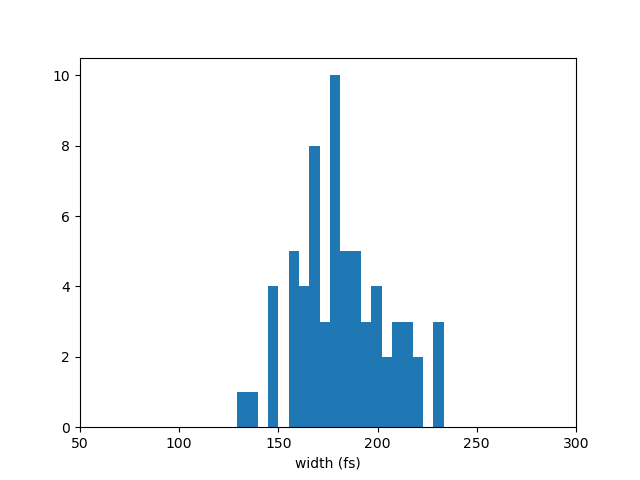

181.5899840502494 22.86799099105561


In [55]:
plt.figure()
plt.hist(abs(np.array(width_fs_loop)), bins = 20)
plt.xlabel('width (fs)')
plt.xlim(50,300)
plt.show()

print (np.mean(width_fs_loop), np.std(width_fs_loop))

<IPython.core.display.Javascript object>


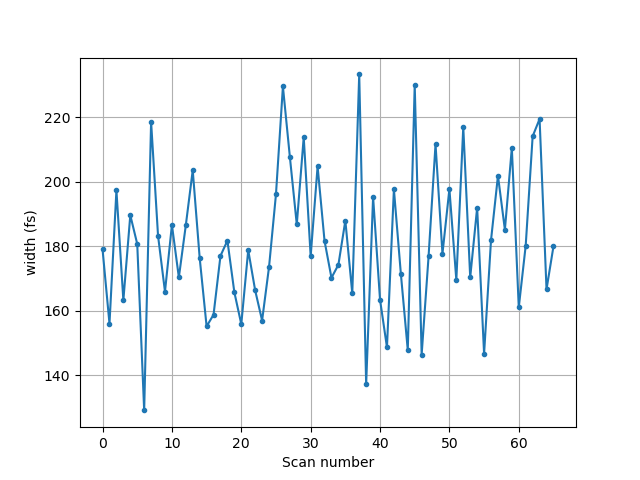

In [56]:
plt.figure()
plt.plot(width_fs_loop, marker = '.')
plt.xlabel('Scan number')
plt.ylabel('width (fs)')
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


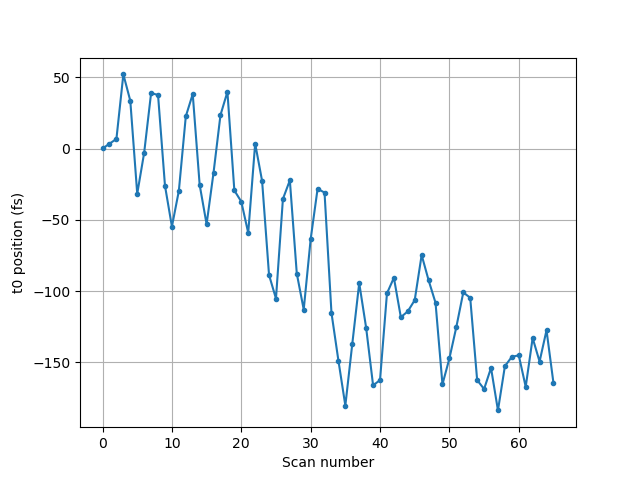

In [58]:
plt.figure()
plt.plot(t0_fs_loop, marker = '.')
plt.xlabel('Scan number')
plt.ylabel('t0 position (fs)')
#plt.ylim(-80,80)
plt.grid()
plt.show()

In [60]:
print (np.mean(t0_fs_loop), np.nanmedian(t0_fs_loop))

-77.2966295907514 -91.56308766750256


## with TT correction

In [3]:
from scipy import optimize
from scipy.interpolate import interp1d
from scipy import signal
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d
from scipy.stats import binned_statistic
from scipy.ndimage import gaussian_filter1d
from scipy.ndimage import convolve1d
from scipy.special import erf

lambdas = 467.55 + 0.07219*np.arange(0,2047)      #calibration new spec 23-9-2020
nus = 299792458 / (lambdas * 10**-9)
nus_new = np.linspace(nus[0], nus[-1], num=2047, endpoint=True)
#filter = np.concatenate((np.ones(5), 1-signal.tukey(65), np.ones(1430), np.zeros(1500)))
filter = np.concatenate((np.ones(50),signal.tukey(40)[20:40], np.zeros(1977), np.zeros(2047)))
filter3 = np.concatenate((np.zeros(100), np.ones(100)))
pixelNum = np.arange(0,2047)

background_from_fit = np.loadtxt('/sf/alvra/data/p17589/scratch/2020-10-10-16:10-psen-background.txt')

px2fs = 1.993008440575784      # new spectrometer, it is ~ 2 px to fs
p0 = 1024

In [4]:
quantile_laser = 0.68

Timezero_loop = 211.93414
binsize = 10 # in fs

channel_list_pp = [channel_Events, channel_LaserDiode, channel_Laser_refDiode, channel_delay_harm,
                   channel_PSEN_signal, channel_PSEN_bkg]
channel_list_all = channel_list_pp # + [channel_Izero117]

########################################################################
import itertools

run_number = []
pid_number = []
width_fs_loop_TT = []
t0_fs_loop_TT =[]
edgePosRuns = []
edgePosScans = []

for json_file in datafiles[:2]:
    print (json_file)

    with open(json_file) as file:
        data = json.load(file)
    numFiles = len(data['scan_files'])
    #numFiles = 3
    print ("Processing",numFiles,"files")

    Pump_probe_all = []
    Pump_probe = []
    Pump_probe_avg =[]
    Pump_probe_std = []
    Pump_probe_std_err = []
    Delay_mm = []
    Delays_stage = []
    Delay_fs_stage = []
    edgePos = []
    sigtraces = []
    peaktraces = []

    for i in range(0,numFiles):
        edgePos_singleRun = []
        filename = (data['scan_files'][i])
        testdata = check_files_and_data(filename[0])
        avoid = (int(filename[0].split('/')[-1].split('.')[0].split('_')[-1]) != 4377)
        
        if (testdata) and (avoid): # and (i!=16):
            clear_output(wait=True)
       
            print("step",i+1,"of",numFiles,": Processing %s" % (filename))
            run_number.append(int(filename[0].split('_')[-1].split('.')[0]))
        
            resultsPP, results_FEL, pids_pump, pids_unpump = load_data_compact_FEL_pump(channel_list_pp, channel_list_all, filename[0])
            
            pid_number.append(pids_pump[0])
            #(Laser_pump, Laser_unpump, Laser_ref_pump, Laser_ref_unpump, Izero_FEL, PIPS, delay, pids_loop) = \
            #load_YAG_events(str(data['scan_files'][i][0]))
        
            Laser_pump = resultsPP[channel_LaserDiode].pump
            Laser_ref_pump = resultsPP[channel_Laser_refDiode].pump
            Laser_unpump = resultsPP[channel_LaserDiode].unpump
            Laser_ref_unpump = resultsPP[channel_Laser_refDiode].unpump
            
            sig = resultsPP[channel_PSEN_signal].pump
            back = resultsPP[channel_PSEN_bkg].pump
            delay_shot = resultsPP[channel_delay_harm].pump
            
            delay_shot_fs = (delay_shot - Timezero_loop)*2/(3e8*1e3*1e-15)
            Delay_fs_stage.append(delay_shot_fs.mean())
        
            #Izero_FEL = results_FEL[channel_Izero117]
        
            Laser_diff = -np.log10((Laser_pump) / (Laser_unpump))
        
            Pump_probe_all.append(Laser_diff)
            df_pump_probe = pd.DataFrame(Laser_diff)
            Pump_probe.append(np.nanquantile(df_pump_probe, [0.5, 0.5 - quantile_laser/2, 0.5 + quantile_laser/2]))
        
            for k in range(0, len(sig)):
                # background subtraction
                sig2 = np.nan_to_num(sig[k] / back[k]) / background_from_fit
    
                # interpolate to get evenly sampled in frequency space
                sig3inter = interp1d(nus, sig2, kind='cubic')
                sig4 = np.pad(sig3inter(nus_new), (0,len(sig3inter(nus_new))), 'constant', constant_values=0)
                sig4power = np.abs(np.fft.fft(sig4))**2

                # Fourier transform, filter, inverse fourier transform, take the real part, and do a moving average
                sig4fft = np.fft.fft(sig4)
                sig4filtered = sig4fft * filter
                sig4inverse = np.fft.ifft(sig4filtered)
                sig4invreal = 2 * np.real(sig4inverse)
            
                sig4inter = interp1d(nus_new, sig4invreal[0:2047], kind='cubic')
                sig5 = sig4inter(nus)
                sig5gaussO0 = gaussian_filter1d(sig5, 50)
                sig5gaussO1 = gaussian_filter1d(sig5, 50, order = 1)
                sig6 = np.roll(convolve1d(sig5gaussO0,filter3), -100)
    
                peak2 = np.argmax(sig5gaussO1)
        
                #if (peakxcorr > 0) & (peak2.max() > 0.05): 
                edgePos.append(peak2)
                edgePos_singleRun.append(peak2)
                Delays_stage.append(np.round(np.mean(delay_shot_fs),4))
                sigtraces.append(sig6)
                peaktraces.append(sig5gaussO1)
                #Pump_probe_all.append(Laser_diff)
                #edgeSig.append(sig5)
            
            edgePosRuns.append(np.array(np.nanmean(edgePos_singleRun))) 
    edgePosScans.append(np.nanmean(edgePosRun))
            
    Pump_probe_all = list(itertools.chain.from_iterable(Pump_probe_all))
    Delays_corr = Delays_stage + ((p0 - np.array(edgePos))*px2fs)
        
    print (np.shape(Pump_probe_all),np.shape(Delays_corr))
    
    binList = np.arange(Delay_fs_stage[0], Delay_fs_stage[-1], binsize)
    xAxis = np.arange(Delay_fs_stage[0] + binsize/2, Delay_fs_stage[-1] - binsize/2, binsize)
    
    s, binEdges, binNumber = binned_statistic(Delays_corr, Pump_probe_all, statistic='mean', bins=binList)
    
    index = ~(np.isnan(xAxis) | np.isnan(s))
    parameters_TTcorr,extras = curve_fit(errfunc_fwhm, xAxis[index], s[index], p0 = [0, 0.2, 0, 100])
    t0_TTcorr = parameters_TTcorr[2]
    width_TTcorr = parameters_TTcorr[3]
    
    t0_fs_loop_TT.append(t0_TTcorr)
    width_fs_loop_TT.append(width_TTcorr)
    
    

step 51 of 51 : Processing ['/sf/alvra/data/p17589/raw/scan_data/Loop_thin_YAG_scan_harm_1/run_002712.BSREAD.h5']
Pump rep rate (FEL) is 50.0 Hz
Probe rep rate (laser) is 100.0 Hz

--------------------------------------------------------------------------------

SAR-CVME-TIFALL5:EvtSet                     1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M2.roi_background_x_profile 1000 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M2.roi_signal_x_profile     1000 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LMOT-M453:ENC_1_BS                  1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LSCP1-FNS:CH0:VAL_GET               1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LSCP1-FNS:CH2:VAL_GET               1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 1000 / 1001 -> 0% loss
complete channels: 4 / 6 -> 33% incomplete

--------------------------------------------------------------------------------

(25388,) (25388,)


<IPython.core.display.Javascript object>


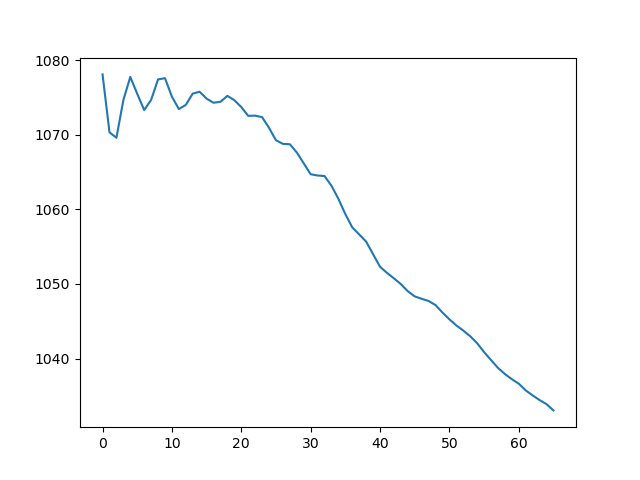

In [52]:
plt.figure()
plt.plot(edgePosScan_all)
plt.show()

In [44]:
edgePosRun_all = edgePosRun.copy()
edgePosScan_all = edgePosScan.copy()
run_number_all = run_number.copy()

In [51]:
len(run_number_all)

3366

<IPython.core.display.Javascript object>


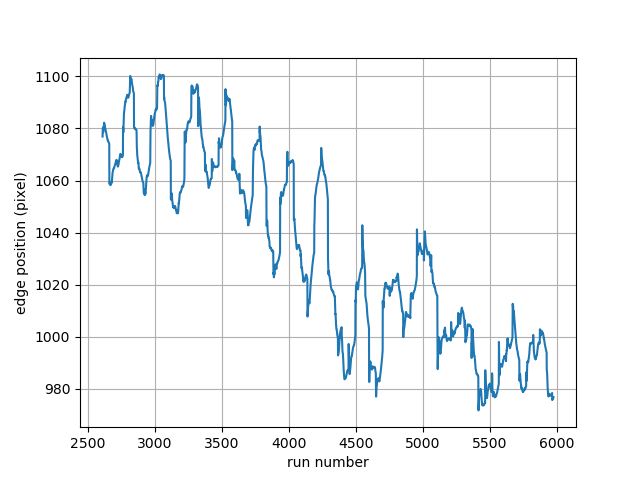

In [42]:
plt.figure()
plt.plot(run_number, edgePosRun)
plt.xlabel('run number')
plt.ylabel('edge position (pixel)')
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


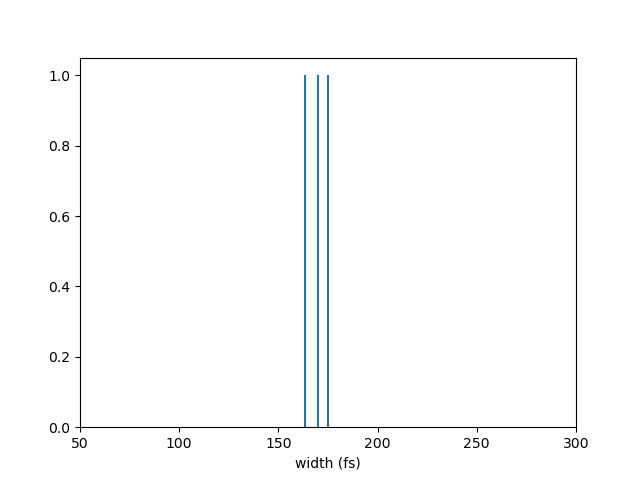

169.47577030012445 5.09547344353328


In [14]:
plt.figure()
plt.hist(abs(np.array(width_fs_loop_TT)), bins = 15)
plt.xlabel('width (fs)')
plt.xlim(50,300)
plt.show()

print (np.mean(width_fs_loop_TT), np.std(width_fs_loop_TT))

<IPython.core.display.Javascript object>


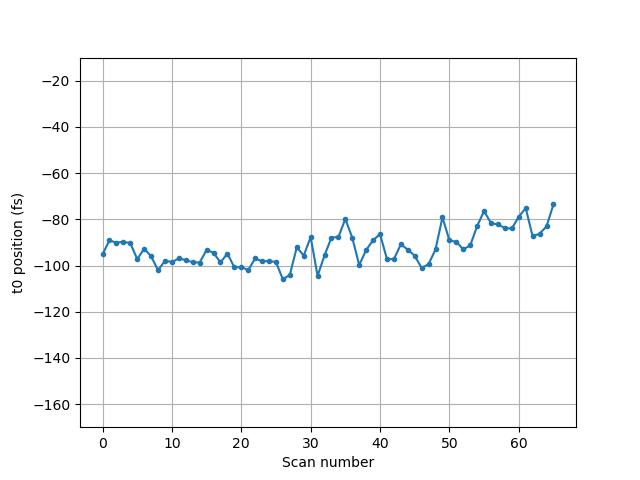

In [53]:
plt.figure()
plt.plot(t0_fs_loop_TT, marker = '.')
plt.xlabel('Scan number')
plt.ylabel('t0 position (fs)')
plt.ylim(-80-90,80-90)
plt.grid()
plt.show()

In [54]:
print (np.mean(t0_fs_loop_TT), np.std(t0_fs_loop_TT))

-92.2769874080677 7.455988678927268


# From here with TT (PALM) jitter correction

In [9]:
import photodiag

#DIRcalib = '/sf/photo/src/PALM/calib/'
#DIRcalib = '/sf/photo/src/PALM/calib/Alvra'
#DIRcalib = '/sf/alvra/data/p18182/res/PhotoDiag/scan_info/'
DIRcalib = '/sf/alvra/data/p17589/res/PhotoDiag/scan_info/'

CalibrationFn = DIRcalib + '2020-07-03_10:44:41.palm_etof'

energyFrom =  2200
energyTo =    2500
energySteps = 2000
palm = photodiag.PalmSetup({'0': 'SAROP11-PALMK118:CH1_BUFFER', '1': 'SAROP11-PALMK118:CH2_BUFFER'},
                 noise_range=[0, 250],
                 energy_range=np.linspace(energyFrom, energyTo, energySteps))


palm.load_etof_calib(CalibrationFn)

### Choose the json file:

In [10]:
fc = FileChooser('/sf/alvra/data/p17589/res/scan_info/') #this is for slic
#fc = FileChooser('/sf/alvra/data/p17589/raw/scan_info/')  #this is for RC
display(fc)

FileChooser(path='/sf/alvra/data/p17589/res/scan_info', filename='', show_hidden='False')

In [44]:
channel_list_pp = [channel_Events, channel_LaserDiode, channel_Laser_refDiode]
channel_list_all = channel_list_pp + [channel_Izero122, channel_delay_harm, channel_PALM_streak, channel_PALM_unstreak]

quantile_laser = 0.5
minlen = 1497
ev2fsCalib= -3.1824981756907595    # scan0000_2020-07-03-thz-time-calib-slic_004
Timezero = 190.10554              # This is from above
#modulo = 2                        # This is for FEL/50Hz -- laser/100Hz
                
########################################################################


###########################################################################################
json_file = fc.selected
#json_file = DIR_json + scan_name + scan_range + ".json"
#json_file = DIR_json + "scan0010_2020-07-03-SiN4_5_scan_info.json"

with open(json_file) as file:
    data = json.load(file)
numFiles = len(data['scan_files'])
#numFiles = 1
print ("Processing",numFiles,"files")
print (json_file)

Pump_probe = []
Pump_probe_avg =[]
Pump_probe_all = []
Delays_stage_mm = []
Delays_PALM_all = []

for i in range(0,numFiles):
    filename = (data['scan_files'][i])
    testdata = check_files_and_data(filename[0])

    if (testdata):# and (i!=12):
        clear_output(wait=True)
        print("step",i+1,"of",numFiles,": Processing %s" % (str(data['scan_files'][i][0])))
    
        results_pp, results_FEL, FEL_reprate, laser_reprate = \
        load_data_compact_FEL_pump(channel_list_pp, channel_list_all, filename[0])
        
        Laser_pump = results_pp[channel_LaserDiode].pump
        Laser_unpump = results_pp[channel_LaserDiode].unpump
        Laser_ref_pump = results_pp[channel_Laser_refDiode].pump
        Laser_ref_unpump = results_pp[channel_Laser_refDiode].unpump
        Event_code = results_pp[channel_Events].unpump
        
        TOF = results_FEL[channel_PALM_streak]
        uTOF = results_FEL[channel_PALM_unstreak]
        Izero_FEL = results_FEL[channel_Izero122]
        Delay_shot = results_FEL[channel_delay_harm]
        
        prep_data = {"0":uTOF, "1":TOF}
        delays_PALM_eV, _, (input_data, lags, cross_corr, _) = palm.process(prep_data, debug=True, peak='com')
        delays_PALM_fs = delays_PALM_eV * ev2fsCalib
        
        Laser_diff = -np.log10((Laser_pump) / (Laser_unpump))
        Laser_diff = -np.log10((Laser_pump/Laser_ref_pump) / (Laser_unpump/ Laser_ref_unpump)) #/ (Izero_FEL)
        
        Laser_diff = Laser_diff[:minlen]
        delays_PALM_fs = delays_PALM_fs[:minlen]
        Izero_FEL = Izero_FEL[:minlen]
        
        fullArraySize = len(delays_PALM_fs)
        #delays_PALM_fs = delays_PALM_fs[:fullArraySize]
        #Izero_FEL = Izero_FEL[:fullArraySize]
        beamOK = (Izero_FEL > 2)
            
        delays_beamOK = delays_PALM_fs[beamOK]
        NumberOK = len(delays_beamOK) 
        shots2pad = fullArraySize - NumberOK
        try:       
            delays_beamOK = np.pad(delays_beamOK, (0, shots2pad), constant_values=np.NaN)
            Laser_diff = np.pad(Laser_diff, (0, len(delays_beamOK)-len(Laser_diff)), constant_values=np.NaN)
            print ('Ratio light/dark is {}:1 at pump rep rate {} Hz, light shots are {}, need to pad {} shots' \
                   .format(laser_reprate, FEL_reprate, NumberOK, shots2pad))
        except:
            print ('Ratio light/dark is {}:1 at pump rep rate {} Hz, they are not commensurate, cannot pad. Keep {} light shots' \
                   .format(laser_reprate, FEL_reprate, NumberOK))
                       
        df_pump_probe = pd.DataFrame(Laser_diff)
        Pump_probe.append(np.quantile(df_pump_probe, [0.5, 0.5 - quantile_laser/2, 0.5 + quantile_laser/2]))
            
        Pump = np.median(Laser_pump)
        Unpump = np.median(Laser_unpump)
        Pump_probe_avg.append(-np.log10((Pump) / (Unpump)))
        
        #Delays_stage_mm.append(data['scan_readbacks'][i]) ## Delay from the json file
        
        Delay_shot = [x for x in Delay_shot if (np.abs(x) > 0)]
        Delays_stage_mm.append([np.median(Delay_shot)])
        
        Delays_PALM_all.append(delays_beamOK)
        
        Pump_probe_all.append(Laser_diff)
        

Pump_probe = np.asarray(Pump_probe)
Pump_probe_avg = np.asarray(Pump_probe_avg)
Pump_probe_all = np.asarray(Pump_probe_all)
Delays_stage_mm = np.asarray(Delays_stage_mm)
Delays_PALM_all = np.asarray(Delays_PALM_all)
        
Delays_stage_fs = (Delays_stage_mm - Timezero)*2/(3e8*1e3*1e-15) # change to right t0 !

print ("PBPS data of the last step have {} shots, avg intensity = {} +/- {}".format(len(Izero_FEL),round(np.average(Izero_FEL),4), round(np.std(Izero_FEL),4)))
print ("Quantile range = {}".format(0.5 - quantile_laser/2), 0.5 + quantile_laser/2)
print ("Loaded {} files, size of the arrays = {}".format(numFiles, len(Pump_probe)))

step 51 of 51 : Processing /sf/alvra/data/p17589/raw/scan_data/scan0010_2020-07-03-SiN4_5/scan0010_2020-07-03-SiN4_5_step0050/run_001152.*.h5
Pump rep rate (FEL) is 50.0 Hz
Probe rep rate (laser) is 100.0 Hz

--------------------------------------------------------------------------------

SAR-CVME-TIFALL5:EvtSet       3001 / 3001 ->  0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PALMK118:CH1_BUFFER   1501 / 3001 -> 50% loss ▇▇▇▇▇
SAROP11-PALMK118:CH2_BUFFER   1501 / 3001 -> 50% loss ▇▇▇▇▇
SAROP11-PBPS122:INTENSITY     1501 / 3001 -> 50% loss ▇▇▇▇▇
SLAAR11-LMOT-M453:ENC_1_BS    3000 / 3001 ->  0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LSCP1-FNS:CH0:VAL_GET 3001 / 3001 ->  0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LSCP1-FNS:CH2:VAL_GET 3001 / 3001 ->  0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 1500 / 3001 -> 50% loss

--------------------------------------------------------------------------------

Ratio light/dark is 1:1 at pump rep rate 50.0 Hz, light shots are 1496, need to pad 1 shots
PBPS data of the last step have 1497 shots, 

In [45]:
print (Delays_PALM_all.shape, Pump_probe_all.shape, Delays_stage_mm.shape)

(51, 1497) (51, 1497) (51, 1)


<IPython.core.display.Javascript object>


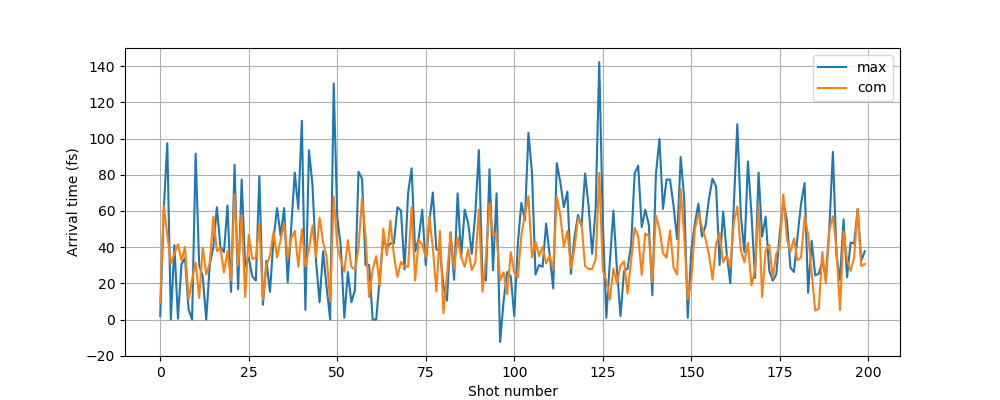

In [56]:
#delays_max = np.copy(Delays_PALM_all.ravel())
plt.figure(figsize=(10,4))
plt.plot (delays_max[0:200], label = 'max')
plt.plot (delays_com[0:200], label = 'com')
plt.legend(loc='best')
plt.xlabel('Shot number')
plt.ylabel('Arrival time (fs)')
plt.grid()
plt.show()
plt.savefig (savedir + 'SiN_5_TT_comp_MAXvsCOM.png')

In [57]:
for i in range (Delays_PALM_all.shape[0]):
    print (i, np.nanmedian(Delays_PALM_all[i,:]))
    
np.nanmean(Delays_PALM_all)

0 40.35072403628929
1 34.86412790482618
2 44.06950033743856
3 44.940628096864124
4 40.10369703049535
5 40.17376515933261
6 36.934894499513504
7 29.943688729447352
8 32.35499757104007
9 27.79932794490612
10 25.671543016601564
11 29.623838926886073
12 29.421636813085634
13 33.75342271275525
14 31.985051670899274
15 27.17755364610991
16 30.684858770335055
17 31.242061667178167
18 37.19486758161104
19 31.61335819976801
20 25.25491148514783
21 31.03805753779881
22 28.189599730399816
23 29.358373358414468
24 29.743156024715333
25 25.538203169554997
26 21.40001566461083
27 20.334143297328808
28 28.795220404484212
29 23.568857780668292
30 14.86855541800184
31 19.574073566043232
32 20.579233301764425
33 24.465725856685623
34 22.1487709127296
35 15.86877103593267
36 14.763327560527378
37 15.05157386848534
38 24.046417823083353
39 24.346932216227074
40 27.79309005740829
41 34.51280066437353
42 25.31405882069463
43 21.192415770212985
44 28.19796083334588
45 27.751322983056752
46 26.789310035789708

28.030846417728615

<IPython.core.display.Javascript object>


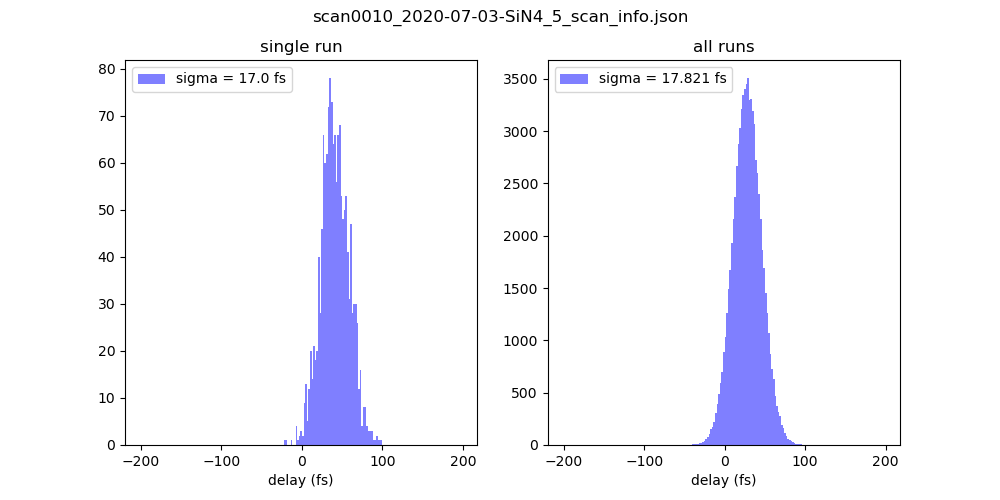

In [46]:
plt.figure(figsize=(10,5))
plt.suptitle(fc.selected_filename)

plt.subplot(121)
#plt.hist((Delays_PALM_all[0]-np.nanmean(Delays_PALM_all[0,:])), bins =np.arange(-200,200,2), facecolor='blue', \
#         label="sigma = {} fs".format(np.round(np.nanstd(Delays_PALM_all[0,:]-np.nanmean(Delays_PALM_all)), 3), alpha=0.5))
plt.hist((Delays_PALM_all[0]), bins =np.arange(-200,200,2), facecolor='blue', \
         label="sigma = {} fs".format(np.round(np.nanstd(Delays_PALM_all[0,:])), 3), alpha=0.5)

plt.title('single run')
plt.legend(loc="best")
plt.xlabel ('delay (fs)')
plt.show()

plt.subplot(122)
#plt.hist((Delays_PALM_all.ravel()-np.nanmean(Delays_PALM_all.ravel())), bins =np.arange(-200,200,5), facecolor='blue', \
#         label="sigma = {} fs".format(np.round(np.nanstd(Delays_PALM_all.ravel()-np.nanmean(Delays_PALM_all)), 3), alpha=0.5))
plt.hist(((Delays_PALM_all.ravel())), bins =np.arange(-200,200,2), facecolor='blue', \
         label="sigma = {} fs".format(np.round(np.nanstd(Delays_PALM_all.ravel()), 3)), alpha=0.5)
plt.title('all runs')
plt.legend(loc="best")
plt.xlabel ('delay (fs)')
plt.show()
plt.savefig (savedir + 'SiN_5_TT_hist_MAX.png')

In [47]:
def CorrectJitterSignal(DelaysPALM_fs, DelaysSTAGE_fs, Signal, reBinFac, quantile_rebin):
    print (DelaysPALM_fs.shape, DelaysSTAGE_fs.shape, Signal.shape)
    #Delaystmp = DelaysRAW#*calibPALM
    CorrectedTime = DelaysSTAGE_fs - ((DelaysPALM_fs)-(np.nanmean(DelaysPALM_fs)))
    PALMSteps =  DelaysSTAGE_fs.shape[0]*reBinFac
    CorrectedTime = CorrectedTime.ravel()
    binsCentre = np.linspace(DelaysSTAGE_fs[0], DelaysSTAGE_fs[-1], PALMSteps)
    
    digi = np.digitize(CorrectedTime, binsCentre[:,0])
    
    signalProc = []
    signalProc_Q = []
    signalProcSS = []
    Num_points = []
    
    for i in range(PALMSteps):
        ind = digi==i+1
        num_points = np.count_nonzero(ind)
        signalProc.append(np.nanmedian(Signal[ind]))
        signalProcSS.append(Signal[ind])
        Num_points.append(num_points)
        df_signal = pd.DataFrame(Signal[ind])
        signalProc_Q.append(np.nanquantile(df_signal, [0.5, 0.5 - quantile_rebin/2, 0.5 + quantile_rebin/2]))
        
        
    signalProc= np.array(signalProc)
    signalProc_Q= np.array(signalProc_Q)
    signalProcSS= np.array(signalProcSS)
    Num_points = np.asarray(Num_points)

    return binsCentre, CorrectedTime, signalProc, signalProc_Q, signalProcSS, Num_points

In [51]:
quantile_reBin = 0.5
reBin_factor = 2

############################################################################

BinsCentre, CorrectedTime, Signal, Signal_Q, SignalSS, ShotsPerBin = \
CorrectJitterSignal(Delays_PALM_all, Delays_stage_fs, Pump_probe_all.ravel(), reBin_factor, quantile_reBin)

(51, 1497) (51, 1) (76347,)


<IPython.core.display.Javascript object>


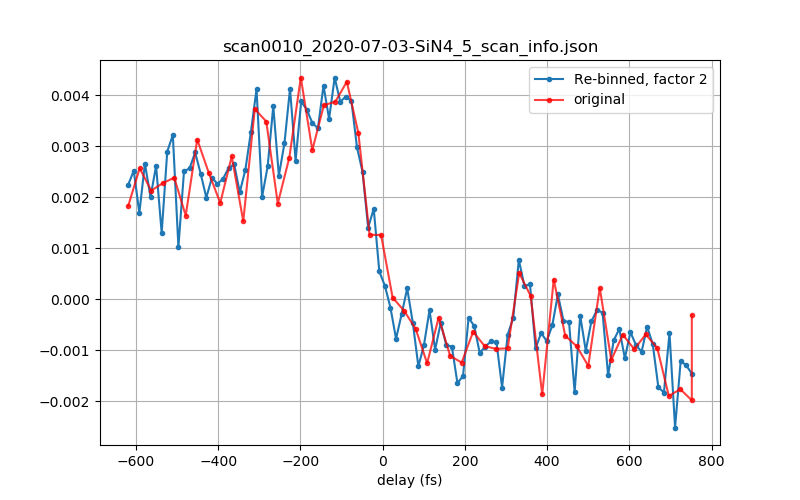

In [52]:
sig = Signal
plt.figure(figsize = (8,5))
plt.title (fc.selected_filename)

#for i in range(len(BinsCentre)):
#    xe = BinsCentre[i]
#    ye = SigSS[i]
#    plt.plot([xe] * ShotsPerBin[i], ye, 'r.', ms=.5, alpha=0.8)
plt.plot (BinsCentre.ravel(), sig, label='Re-binned, factor {}'.format(reBin_factor), marker = '.')

plt.plot(Delays_stage_fs, pp, label='original', color = 'r', marker='.', alpha = 0.75)
#plt.fill_between(np.squeeze(Delay_ps_toFit*1000), err_pp_low, err_pp_high, color='navajowhite',  alpha = 0.3)

plt.legend(loc="best")
plt.xlabel("delay (fs)")
plt.grid()
#plt.xlim(-700, 300)
plt.show()
plt.savefig (savedir + 'SiN_5_TT_rebin_factor2_com.png')

<IPython.core.display.Javascript object>


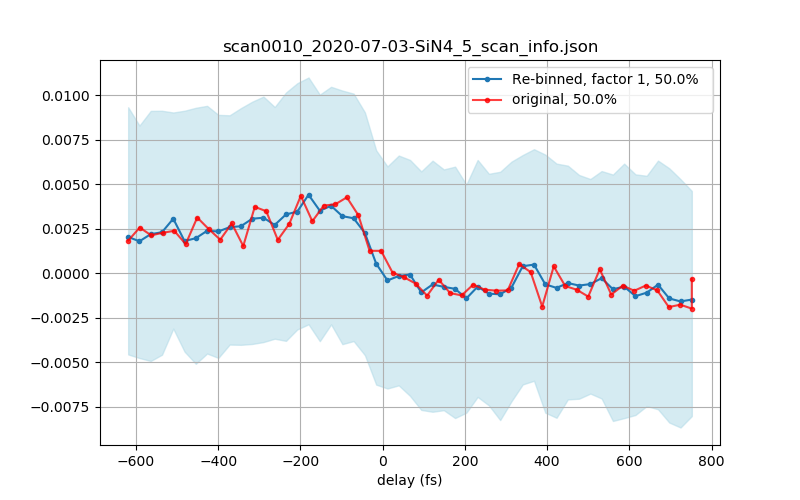

In [21]:
sig = Signal_Q[:,0]
err_sig_low = Signal_Q[:,1]
err_sig_high = Signal_Q[:,2]

plt.figure(figsize = (8,5))
plt.title (fc.selected_filename)

#for i in range(len(BinsCentre)):
#    xe = BinsCentre[i]
#    ye = SigSS[i]
#    plt.plot([xe] * ShotsPerBin[i], ye, 'r.', ms=.5, alpha=0.8)
plt.plot (BinsCentre.ravel(), sig, label='Re-binned, factor {}, {}%  '.format(reBin_factor, quantile_reBin*100), marker = '.')
plt.fill_between(BinsCentre.ravel(), err_sig_low, err_sig_high, color='lightblue',  alpha = 0.5)

plt.plot(Delays_stage_fs, pp, label='original, {}%'.format(quantile_laser*100), color = 'r', marker='.', alpha = 0.75)
#plt.fill_between(np.squeeze(Delay_ps_toFit*1000), err_pp_low, err_pp_high, color='navajowhite',  alpha = 0.3)

plt.legend(loc="best")
plt.xlabel("delay (fs)")
plt.grid()
plt.show()
#plt.savefig (savedir + scan_name + 'TT_rebin.png')

In [50]:
# Now fit IN TIME with error funciton (defined above)
index = ~(np.isnan(BinsCentre.ravel()) | np.isnan(sig))
parameters_fs,extras = curve_fit(errfunc_fwhm, BinsCentre.ravel()[index], sig[index], p0 = [0, 0.2, 0, 100])
t0_fs = parameters_fs[2]
width_fs = parameters_fs[3]

print("Position t0 =",np.round(t0_fs,5),"fs")
print("Width =",np.abs(np.round(width_fs,5)),"fs")

Position t0 = -21.33079 fs
Width = 50.31587 fs


<IPython.core.display.Javascript object>


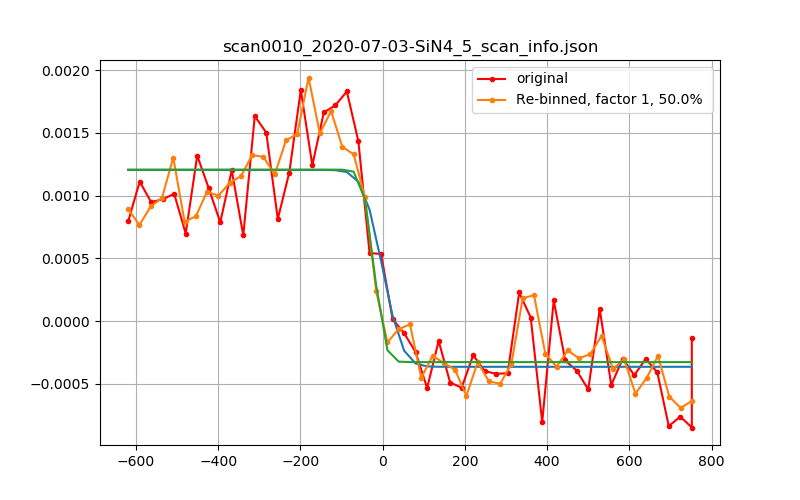

<function matplotlib.pyplot.show(*args, **kw)>

In [51]:
plt.figure(figsize = (8,5))
plt.title (fc.selected_filename)

plt.plot (Delays_stage_fs, pp, marker = '.', label ='original', color = 'r')
plt.plot(Delays_stage_fs, errfunc_fwhm(Delay_ps_toFit,*parameters_ps))

plt.plot (BinsCentre.ravel(), sig, label='Re-binned, factor {}, {}% '.format(reBin_factor, quantile_reBin*100), marker = '.')
plt.plot (BinsCentre.ravel(), errfunc_fwhm(BinsCentre.ravel(), *parameters_fs))
plt.grid()
plt.legend(loc='best')
plt.show



In [ ]:
time_zero =  149.6658   #this is in mm from the delay scans (offset of 70 um due to air vs He[100 mbar])

desidered_delay = 3        #choose this in ps

delay_to_set = (100/(2*333))*desidered_delay + time_zero        #factor of 2 because of the delay stage

desidered_delay + time_zero
print ("To be at",desidered_delay,"ps, put the laser pump delay stage to",np.round(delay_to_set,4),"mm")

In [2]:
offset_space = 200       # this is in um

offset_time = 2*(offset_space * 1e-6)/3e8/1e-15            #factor of 2 because of the delay stage, results in fs
print ("An offset of",offset_space,"um corresponds to an offset of",np.round(offset_time,4),"fs")

An offset of 2000 um corresponds to an offset of 13333.3333 fs


In [5]:
offset_time = 500e3      # this is in fs

offset_space = 3e8 * (offset_time * 1e-15)/2/1e-6          #factor of 2 because of the delay stage, results in um
print ("An offset of",offset_time,"fs corresponds to an offset of",np.round(offset_space,4),"um")

An offset of 500000.0 fs corresponds to an offset of 75000.0 um


In [ ]:
195.2-(105.9-88.35)

In [ ]:
# Check if the condition on the intensity makes sense by looking at the total histogram. §

Izero_total_1D = np.hstack(Izero_FEL_all)
Izero_total_1D_filter = np.hstack(Izero_FEL_all_filter)

print ("Total shots=",Izero_total_1D.size,"// filtered=,",Izero_total_1D_filter.size)
plt.figure()

### ALL STEPS ###
plt.hist(Izero_total_1D_filter, bins = np.arange(0,2,0.01), facecolor='red', alpha=0.5)
plt.hist(Izero_total_1D, bins = np.arange(0,2,0.01), facecolor='blue', alpha=0.5)

### ONLY THE LAST STEP ###
#plt.hist(Izero_FEL, bins = np.arange(0,1.5,0.01), facecolor='blue', alpha=0.5)
#plt.hist(Izero_FEL_filter, bins = np.arange(0,1.5,0.01), facecolor='orange', alpha=0.5)

plt.xlim(0,2)
plt.title(DIR)

plt.show()